In [1]:
#titanic에서 데이터 분석한 결과를 가지고 데이터를 전처리 한후 Xgboost를 사용해서 예측률을 높여본다.
# Xgboost에서 하이퍼파라미터를 어떻게 조정할지에 대한 방법을 연습한다.
# 여기서는 Xgboost model에 대한 이해를 높이는데 중점을 둔다.
# Bayesian Optimization를 적용
# 2020.5.14

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score
from sklearn.metrics import f1_score, roc_auc_score, roc_curve
# 사이킷런 래퍼 XGBoost 클래스인 XGBClassifier 임포트
from xgboost import XGBClassifier
import xgboost as xgb
from bayes_opt import BayesianOptimization

titanic_data = pd.read_csv('titanic_train.csv')
titanic_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [2]:
#불필요한 요소 삭제
titanic_data = titanic_data.drop(['PassengerId', 'Name', 'Ticket'], axis = 1)
# cabin정보의 missing을 N으로 선실번호에서 앞자만 사용
titanic_data.Cabin.fillna('N', inplace = True)
titanic_data['H_Cabin'] = titanic_data['Cabin'].apply(lambda x : x[0])
#missing value 처리
#Age는 평균값으로 처리
titanic_data.Age.fillna(titanic_data.Age.mean(), inplace = True)
#Cabin은 삭제하고 H_cabin사용
titanic_data = titanic_data.drop(['Cabin'], axis = 1)
#Embarked는 가장 많은  S로
titanic_data.Embarked.fillna('S', inplace = True)
titanic_data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,H_Cabin
0,0,3,male,22.0,1,0,7.2500,S,N
1,1,1,female,38.0,1,0,71.2833,C,C
2,1,3,female,26.0,0,0,7.9250,S,N
3,1,1,female,35.0,1,0,53.1000,S,C
4,0,3,male,35.0,0,0,8.0500,S,N


In [3]:
# 중요한 요소이긴 하지만 2이상은 데이터가 적어서, 있으면 1 없으면 0으로
titanic_data['SibSp'] = titanic_data['SibSp'].apply(lambda x : 1 if x > 0 else 0)

#분류 값들을 수치값으로 변경
titanic_data.Sex.replace({'male': 0.0, 'female': 1.0}, inplace= True)

#Dependents 값을 get_dummies 함수를 이용해서 수치로 변경 OneHotEncode를 사용해도 된다.
#drop first를 True로 해서 dummy trap을 피한다.
dummies = pd.get_dummies(titanic_data['Embarked'], prefix='Embarked', drop_first=True)
titanic_data = pd.concat([titanic_data, dummies], axis=1)
titanic_data = titanic_data.drop(['Embarked'],  axis=1)

dummies = pd.get_dummies(titanic_data['H_Cabin'], prefix='Cabin', drop_first=True)
titanic_data = pd.concat([titanic_data, dummies], axis=1)
titanic_data = titanic_data.drop(['H_Cabin'],  axis=1)

# 더 많은 column을 보여주도록 변경
pd.set_option('display.max_columns', 100) 
titanic_data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_Q,Embarked_S,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_N,Cabin_T
0,0,3,0.0,22.0,1,0,7.2500,0,1,0,0,0,0,0,0,1,0
1,1,1,1.0,38.0,1,0,71.2833,0,0,0,1,0,0,0,0,0,0
2,1,3,1.0,26.0,0,0,7.9250,0,1,0,0,0,0,0,0,1,0
3,1,1,1.0,35.0,1,0,53.1000,0,1,0,1,0,0,0,0,0,0
4,0,3,0.0,35.0,0,0,8.0500,0,1,0,0,0,0,0,0,1,0


In [4]:
#Test를 위한 데이터 생성
y_data = titanic_data.Survived
x_data = titanic_data.drop('Survived', axis = 1)
#test 와 train set 만들기
X_train, X_test, y_train, y_test= train_test_split(x_data, y_data, test_size=0.2, random_state=123)

In [5]:
import numpy as np
from hyperopt import hp, tpe, fmin

# Single line bayesian optimization of polynomial function
best = fmin(fn = lambda x: np.poly1d([1, -2, -28, 28, 12, -26, 100])(x),
            space = hp.normal('x', 4.9, 0.5), algo=tpe.suggest, 
            max_evals = 2000)

100%|███████████████████████████████████████████| 2000/2000 [00:13<00:00, 151.55trial/s, best loss: -4396.024080099919]


Minimum of -1.0000 occurs at -0.0005


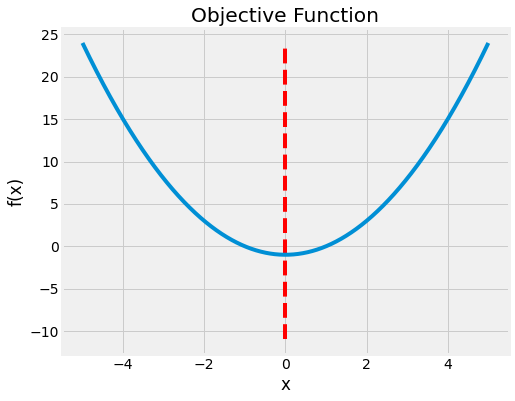

In [6]:
def objective(x):
    """Objective function to minimize"""
    
    # Create the polynomial object
    f = np.poly1d([1,1]) * np.poly1d([1,-1]) 

    # Return the value of the polynomial
    return f(x)

# Space over which to evluate the function is -5 to 6
x = np.linspace(-5, 5, 10000)
y = objective(x)

miny = min(y)
minx = x[np.argmin(y)]

# Visualize the function
plt.figure(figsize = (8, 6))
plt.style.use('fivethirtyeight')
plt.title('Objective Function'); plt.xlabel('x'); plt.ylabel('f(x)')
plt.vlines(minx, min(y)- 10, max(y), linestyles = '--', colors = 'r')
plt.plot(x, y);

# Print out the minimum of the function and value
print('Minimum of %0.4f occurs at %0.4f' % (miny, minx))

# xgb model에 Bayesian Optimization를 적용해서 hyper parameter를 최적화
XGBoost 목표 지표에 가장 큰 영향을 미치는 하이퍼파라미터는 alpha, min_child_weight, subsample, learning_rate 및 n_estimators입니다.
참고 사이트 : https://docs.aws.amazon.com/ko_kr/sagemaker/latest/dg/xgboost-tuning.html
주의할점 : 기본적으로 float값을 parameter로 가정하므로 반드시 정수값을 넣어야 하는 경우는 int(rount())를 사용해서 정수로 변환이 필요.¶
그런데 이 경우 loop에 빠질수가 있으므로 다른 방법도 같이 고려하는게 좋을 수도 있다.

In [7]:
def xgbscore_function(n_e, l_r, m_d, m_c_w, s_s) :
    xgb_wrapper = XGBClassifier(n_estimators=int(round(n_e)), learning_rate=l_r, max_depth=int(round(m_d)), 
                                min_child_weight=int(round(m_c_w)), subsample=s_s, device='gpu')
    xgb_wrapper.fit(X_train, y_train)
    w_preds = xgb_wrapper.predict(X_test)
    score = accuracy_score(y_test, w_preds)
    return score

# Bounded region of parameter space
pbounds = {'n_e': (50, 1000), 'l_r': (0.01, 0.2), 'm_d':(1, 10), 'm_c_w':(0,120), 's_s':(0.5,1)}

optimizer1 = BayesianOptimization(
    f=xgbscore_function,
    pbounds=pbounds,
    verbose=1, # verbose = 1 prints only when a maximum is observed, verbose = 0 is silent
    random_state=1,
)

optimizer1.maximize(
    init_points=3,
    n_iter=50,
)

print(optimizer1.max)

|   iter    |  target   |    l_r    |   m_c_w   |    m_d    |    n_e    |    s_s    |
-------------------------------------------------------------------------------------
|  2        |  0.8212   |  0.02754  |  22.35    |  4.11     |  426.9    |  0.7694   |
|  5        |  0.838    |  0.1462   |  2.313    |  9.511    |  997.3    |  0.8602   |
|  6        |  0.8436   |  0.2      |  0.0      |  10.0     |  696.7    |  1.0      |
|  12       |  0.8603   |  0.169    |  1.37     |  2.324    |  376.8    |  0.554    |
|  15       |  0.8715   |  0.03234  |  0.1286   |  1.979    |  115.5    |  0.622    |
{'target': 0.8715083798882681, 'params': {'l_r': 0.032337147870807825, 'm_c_w': 0.1286395859421141, 'm_d': 1.979107925560805, 'n_e': 115.50124350264203, 's_s': 0.6220098229838444}}


# Bayesian Optimization과 KFold 결합

In [39]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

kfold = StratifiedKFold(n_splits=3, random_state=5)
scores = []
def xgbscore_function(n_e, l_r, m_d, m_c_w, s_s) :
    xgb_model = XGBClassifier(n_estimators=int(round(n_e)), learning_rate=l_r, max_depth=int(round(m_d)), 
                                min_child_weight=int(round(m_c_w)), subsample=s_s)
    results = cross_val_score(xgb_model, X_train, y_train, cv=kfold, scoring='roc_auc')
    score = results.mean()
    scores.append(score)
    return score

# Bounded region of parameter space
pbounds = {'n_e': (50, 1000), 'l_r': (0.01, 0.2), 'm_d':(1, 10), 'm_c_w':(0,120), 's_s':(0.5,1)}

optimizer1 = BayesianOptimization(
    f=xgbscore_function,
    pbounds=pbounds,
    verbose=1, # verbose = 1 prints only when a maximum is observed, verbose = 0 is silent
    random_state=3,
)

optimizer1.maximize(
    init_points=3,
    n_iter=50,
)

print(optimizer1.max)

C:\Users\Professor Lee\anaconda3\envs\tf2\lib\site-packages\sklearn\model_selection\_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


|   iter    |  target   |    l_r    |   m_c_w   |    m_d    |    n_e    |    s_s    |
-------------------------------------------------------------------------------------
|  2        |  0.841    |  0.1803   |  15.07    |  2.865    |  98.89    |  0.7204   |
|  4        |  0.8481   |  0.01     |  0.0      |  10.0     |  1e+03    |  0.5      |
|  5        |  0.8501   |  0.01003  |  1.356    |  6.889    |  997.1    |  0.7133   |
|  17       |  0.851    |  0.03386  |  0.6977   |  8.256    |  101.3    |  0.8352   |
|  25       |  0.8516   |  0.1732   |  1.736    |  1.793    |  80.42    |  0.5722   |
{'target': 0.8516204263459669, 'params': {'l_r': 0.17318628000828745, 'm_c_w': 1.735964982847591, 'm_d': 1.7925195468241553, 'n_e': 80.41865101541458, 's_s': 0.5722429665320778}}


grid로 찾은 최적화 파라미터로 예측

Best Grid Xgbm accuracy score:0.8659
오차 행렬
[[101  13]
 [ 11  54]]
정확도: 0.8659, 정밀도: 0.8060, 재현율: 0.8308,    F1: 0.8182, AUC:0.9092
              precision    recall  f1-score   support

           0       0.90      0.89      0.89       114
           1       0.81      0.83      0.82        65

    accuracy                           0.87       179
   macro avg       0.85      0.86      0.86       179
weighted avg       0.87      0.87      0.87       179



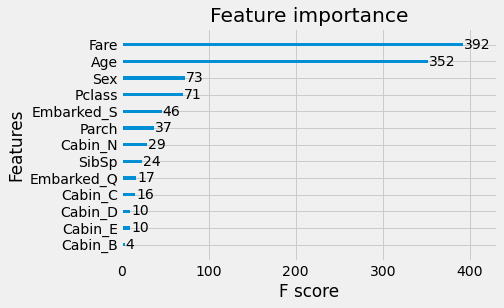

In [37]:
# 평가 함수 선언
def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix( y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    f1 = f1_score(y_test,pred)
    # ROC-AUC 추가 
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차 행렬')
    print(confusion)
    # ROC-AUC print 추가
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f},\
    F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))    
    
best_xgb = XGBClassifier(n_estimators=178, learning_rate=0.06465853014406732, max_depth=3, min_child_weight=1, subsample=0.5521541258084046)
 
best_xgb.fit(X_train, y_train)
preds = best_xgb.predict(X_test)
pred_proba = best_xgb.predict_proba(X_test)[:, 1]

print("Best Grid Xgbm accuracy score:{0:.4f}".format(accuracy_score(y_test,preds)))
get_clf_eval(y_test , preds, pred_proba)
print(classification_report(y_test, preds))
xgb.plot_importance(best_xgb)

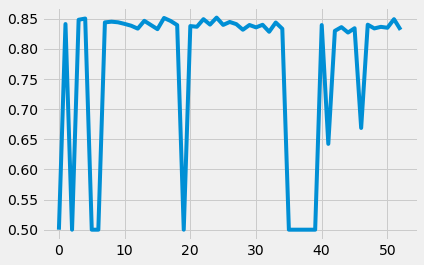

In [41]:
plt.plot(scores)

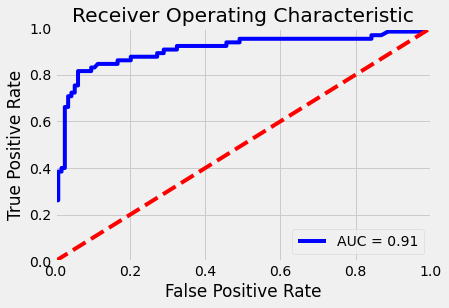

In [50]:
import sklearn.metrics as metrics
# calculate the fpr and tpr for all thresholds of the classification
fpr, tpr, threshold = metrics.roc_curve(y_test, pred_proba)
roc_auc = metrics.auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

첫번째로 파라미터 찾은 파라미터값들로 셋팅 후, 남은 파라미터들을 추가로 찾는다.

In [42]:
def xgbscore_function2(c_b, r_a, gamma) :
    xgb_wrapper = XGBClassifier(n_estimators=178, learning_rate=0.06465853014406732, max_depth=3, min_child_weight=1, 
                                subsample=0.5521541258084046, colsample_bytree=c_b, reg_alpha= r_a, gamma=gamma)
 
    xgb_wrapper.fit(X_train, y_train)
    w_preds = xgb_wrapper.predict(X_test)
    score = accuracy_score(y_test, w_preds)
    return score

# Bounded region of parameter space
pbounds = {'c_b': (0.5, 1), 'r_a': (0,100), 'gamma':(0,0.5)}

optimizer1 = BayesianOptimization(
    f=xgbscore_function2,
    pbounds=pbounds,
    verbose=1, # verbose = 1 prints only when a maximum is observed, verbose = 0 is silent
    random_state=1,
)

optimizer1.maximize(
    init_points=3,
    n_iter=50,
)

print(optimizer1.max)

|   iter    |  target   |    c_b    |   gamma   |    r_a    |
-------------------------------------------------------------
|  7        |  0.8771   |  0.5342   |  0.07756  |  0.02465  |
{'target': 0.8770949720670391, 'params': {'c_b': 0.5341656110758556, 'gamma': 0.07756336091936933, 'r_a': 0.02464858144757276}}


Best Grid Xgbm accuracy score:0.8771
오차 행렬
[[103  11]
 [ 11  54]]
정확도: 0.8771, 정밀도: 0.8308, 재현율: 0.8308,    F1: 0.8308, AUC:0.9055
              precision    recall  f1-score   support

           0       0.90      0.90      0.90       114
           1       0.83      0.83      0.83        65

    accuracy                           0.88       179
   macro avg       0.87      0.87      0.87       179
weighted avg       0.88      0.88      0.88       179



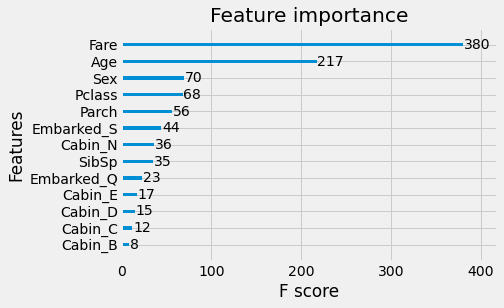

In [43]:
# 베스트 파라미터 모델을 만들고 예측
best_xgb = XGBClassifier(n_estimators=178, learning_rate=0.06465853014406732, max_depth=3, min_child_weight=1, subsample=0.5521541258084046,
                        colsample_bytree=0.5341656110758556, reg_alpha= 0.02464858144757276, gamma=0.07756336091936933)
 
best_xgb.fit(X_train, y_train)
preds = best_xgb.predict(X_test)
pred_proba = best_xgb.predict_proba(X_test)[:, 1]

print("Best Grid Xgbm accuracy score:{0:.4f}".format(accuracy_score(y_test,preds)))
get_clf_eval(y_test , preds, pred_proba)
print(classification_report(y_test, preds))
xgb.plot_importance(best_xgb)

# cross_val_score에 다른 평가 함수를 적용해 보았다.
이부분은 다음을 참조할것 https://scikit-learn.org/stable/modules/model_evaluation.html

In [44]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

kfold = StratifiedKFold(n_splits=3, random_state=5)
scores = []
def xgbscore_function(n_e, l_r, m_d, m_c_w, s_s) :
    xgb_model = XGBClassifier(n_estimators=int(round(n_e)), learning_rate=l_r, max_depth=int(round(m_d)), 
                                min_child_weight=int(round(m_c_w)), subsample=s_s)
    results = cross_val_score(xgb_model, X_train, y_train, cv=kfold, scoring='accuracy')
    score = results.mean()
    scores.append(score)
    return score

# Bounded region of parameter space
pbounds = {'n_e': (50, 1000), 'l_r': (0.01, 0.2), 'm_d':(1, 10), 'm_c_w':(0,120), 's_s':(0.5,1)}

optimizer1 = BayesianOptimization(
    f=xgbscore_function,
    pbounds=pbounds,
    verbose=1, # verbose = 1 prints only when a maximum is observed, verbose = 0 is silent
    random_state=3,
)

optimizer1.maximize(
    init_points=3,
    n_iter=50,
)

print(optimizer1.max)

C:\Users\Professor Lee\anaconda3\envs\tf2\lib\site-packages\sklearn\model_selection\_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


|   iter    |  target   |    l_r    |   m_c_w   |    m_d    |    n_e    |    s_s    |
-------------------------------------------------------------------------------------
|  2        |  0.7964   |  0.1803   |  15.07    |  2.865    |  98.89    |  0.7204   |
|  4        |  0.8132   |  0.01     |  0.0      |  10.0     |  1e+03    |  0.5      |
|  16       |  0.8174   |  0.01507  |  2.137    |  9.025    |  952.3    |  0.5113   |
{'target': 0.8173894030185914, 'params': {'l_r': 0.015067434118446075, 'm_c_w': 2.1369360975944574, 'm_d': 9.024680799355924, 'n_e': 952.321138844336, 's_s': 0.5113009564658697}}
